# Convolutional Neural Network for Chess Piece Classification
##### Alexandru Draghici, MA336 Final Project, July 2021

## Introduction

Recent developments in machine learning methods are known to produce excellent results in object classification, even above human performance in certain instances. The improvements owe themselves on the one hand to improvements in hardware capabilities and on the other hand, to improvements in machine learning technology, a particular instance of which being Convolutional Neural Networks (CNNs).

One classic application of CNNs has been digit and character recognition, whereby a CNN architecture is able to correctly classify human-written symbols with accuracy nearing 100%, lending broad applicability to various real-world tasks. It is also the case that the CNN architecture can be applied to other classification problems and not just simple 2D black-and-white images of pixels, as they are in the popular MNIST database.

There are many motivating applications which can be used to showcase the extended applicability of CNNs, however, a particularly interesting one is the task of classifying chess pieces. The problem has a few added levels of complexity over the aforementioned digit classification because for each chess piece there is an identical one in all aspects except colour. Unedited pictures of chess pieces also occupy three color channels and vary in clarity, angle, and other aspects. In consequence, it would prove interesting to show the performance of a CNN algorithm on identifying such objects as chess pieces.

## The Data

The data were obtained from a public data set for chess piece object recognition, linked in the bibliography section. It contained an original 81 images out of which 33 images contained individual pieces. The chess piece objects were approximately positioned in the center of the image against a white background.

The original images were similar to the following ones:

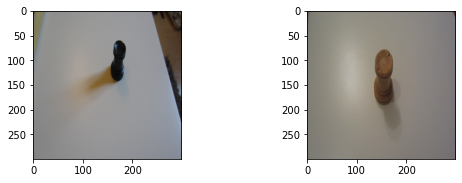

In [25]:
import numpy as np
from tensorflow.keras.preprocessing.image import load_img
from matplotlib import pyplot as plt

# the following images are read from the same folder the notebook is in
img = load_img('IMG_1989.jpg').resize((300,300))
img1 = load_img('IMG_2009.jpg').resize((300,300))
plt.figure(figsize = (9,6))
plt.subplot(221)
plt.imshow(img1)
plt.subplot(222)
plt.imshow(img)

## Preprocessing

Several steps were taken during preprocessing to ensure quality of input for the purpose of better generalisation for the final model.

* Cropping. The center part of each image contained the chess piece wheareas the remaining pixels described the background of the image. An approximate dimension was used to extract the center of the image containing the object of interest;
* Resizing. The original image sizes were 4000x2248 in RGB occupying approximately 1.5mb per image. These were resized to 300x300 pixels to reduce computational demands;
* Augmentation. Due to the reduced number of images in the original data set, for each image, ten additional ones were generated with varying levels of zoom and brightness to improve the variety of the input data;
* Train/test split. The data were split into a 80/20 train-test split for training and validation, whilst ensuring a stratified distribution of samples in both splits;

## Methodology

The main approach was to tune and apply a convolutional neural network on the training set of images for a multi-label classification problem with twelve labels corresponding to each chess piece, six for each side and two colours for each. The performance of the model was evaluated in terms of accuracy and the results were plotted to compare the difference between performance on the training set and on the validation set.

In [26]:
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator as krs_img_generator

from matplotlib import pyplot as plt

import numpy as np
import pandas as pd

### Reading the Data

Each image was read from a folder and converted to PIL format using Keras. Since the images were regular, it was possible to capture the object of interest in the center of the image by providing direct pixel coordinates. After resizing to a computationally-sensible size of 300x300 pixels, the images were stored in array format of shape (33, 300, 300, 3), representing 33 image-arrays of the designated size along three color channels.

In [27]:
from pathlib import Path
import os

# construct the data set, first get all images
# collect images from current wd + images folder
images_folder = Path(os.getcwd() + '/images/').rglob('*.jpg')
images = [x for x in images_folder]  # paths to all images

from tensorflow.keras.preprocessing.image import load_img as krs_load_img
from tensorflow.keras.preprocessing.image import img_to_array as krs_img_to_array


array_images = [] 

for i in range(0,len(images)):   # go through all images and load them using keras
    temp_image = krs_load_img(images[i]).crop((1000,250,3000,1750)).resize((300,300)) # crop the center of the images and resize
    as_array = krs_img_to_array(temp_image)
    array_images.append(as_array)
    
array_images = np.array(array_images) # convert to np array and display shape

array_images.shape # 34 images, 2248x4000 pixels, RGB


(33, 300, 300, 3)

In like manner, the labels which were stored in a separate folder in XML format were read as string elements using Pandas and stored in an array. The order of the labels corresponds to the order of the images, thus at position i the arrays contain a pixel array and its corresponding label.

In [28]:
# construct the data set, get all labels

labels_folder = Path(os.getcwd() + '/annotations/').rglob('*.xml')
labels = [x for x in labels_folder]  # paths to all labels

label_names = []

for i in labels: 
    temp_label = pd.read_xml(i) # read all labels
    label = temp_label.loc[6,'name']
    label_names.append(label)
    
labels_names = np.array(label_names)

label_names[0:6]

['white-rook',
 'white-rook',
 'white-rook',
 'white-knight',
 'white-knight',
 'white-knight']

### Generating Images

One problem with the original data set was that it only contained 33 pictures captured in perfect conditions while in machine learning, the quality of outputs depends on the quality of the input fed to the learning algorithms. An algorithm trained on perfect images might not generalise well to images coming from impromptu settings which are likely to capture the object in an imperfect way. One way of dealing with this problem is to generate additional images with fabricated imperfections or variations.

The augment function returns a modified image of an image in array format which it takes as input, and it modifies it in terms of brightness and zoom. Together with the cropping effect of images, this produces images that resemble real-life inputs more closely. The purpose is to return variations of an original image by generating new ones programmatically instead of collecting additional raw data.

In [29]:
def augment(array): # function to randomly augment images
    samples = np.expand_dims(array, 0)
    
    # vary randomly along levels of zoom and brightness
    datagen = krs_img_generator(zoom_range=[1.0,1.25], brightness_range=[0.5,1.2])
    it = datagen.flow(samples, batch_size=1)
    ige = it.next()
                                                                                
    return ige[0]

In [30]:
# augment images to improve variety in input data

arr_images = np.copy(array_images)
labs = np.copy(label_names)

k = 0
for i in array_images: # for each image, augment 10 more and add them to the data set
    a = []
    
    for j in range(0,10):
        t = augment(i) # augment function
        a.append(t)
    
    a = np.array(a)
    arr_images = np.append(arr_images, a, axis = 0) # added batch of 10 to data set
    
    
    extra_labels = np.repeat(label_names[k], 10) # don't forget about labels
    labs = np.append(labs, extra_labels)
    
    k = k + 1   # k keeps track of the image index to match with label

    # this might not be the best solution but it works because the images and labels are in corresponding order
    # in each of their individual arrays

In [31]:
arr_images.shape, labs.shape # now there are 363 images in the data set

((363, 300, 300, 3), (363,))

### Train/test Split

The pictures in the data set now look like the following ones displayed below.

In order to assess the performance of the learning algorithm, the data should be split in one sample used for training and another used for testing, the latter testing the model's ability to generalise to unseen data. Good performance on the training set in conjuction with poor performance on the test set reflects a model that has overfit the data, i.e. learned it too well and cannot generalise to information it has not yet seen.

The split is performed in a stratified manner, ensuring that there is a proportional number of labels of each class in the the training and test splits.

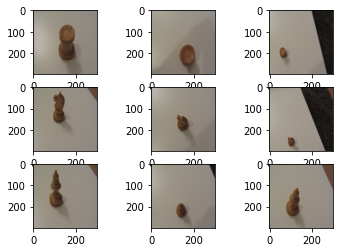

In [32]:
for i in range(0,9):
    plt.subplot(330 + 1 + i)    # showing the first 9 images in the data set ...
    plt.imshow(arr_images[i].astype('uint8'))

(<matplotlib.image.AxesImage at 0x2308842ac10>, 'black-knight')

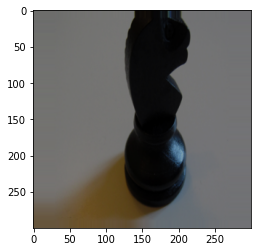

In [33]:
# creating a test/train split

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(arr_images, labs, test_size = 0.2, shuffle = True, stratify = labs)

plt.imshow(X_train[143].astype('uint8')), y_train[143] # the labels match the images ... 


### Normalisation

The images are stored in pixel format, with a value between 0 and 255 for each pixel. To improve the learning process, pixel values are scaled to [0,1]. Furthermore, learning algorithms like numbers. As a result, the twelve classes it is trying to predict are converted first to integers. The problem with this approach is that integers imply order, with 1 being less than 2, and 1/3 of 3, and so on, wheares this information isn't present in the actual categories, so the variables are further encoded into a binary format by being assigned an unique arrangement of 1s and 0s; each arrangement corresponds to one category.

In [34]:
# normalising pixel values

X_train = X_train/255
X_test = X_test/255

In [35]:
# coding to integer and then coding to binary

from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

le = LabelEncoder()

y_train = le.fit_transform(y = y_train)
y_test = le.fit_transform(y = y_test)

y_train = to_categorical(y_train, dtype ="uint8")
y_test = to_categorical(y_test, dtype ="uint8")

In [36]:
y_train.shape, y_test.shape

((290, 12), (73, 12))

### The Model

After using a grid-search approach to identifying the optimal hyperparameters, the final configuration of the model is displayed below. The approach will be using a Convolutional Neural Network with two convolutional layers and two fully connected dense layers. The second convolutional layer has the purpose of identifying larger patterns in the input image than the first 3x3 layer. The kernels are initialised using values from a normal distribution. The full model specifications are summarised below.

In [37]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras.optimizers import Adam

def define_model():
    # Define the Sequential model class for our case
    model = Sequential()
    # Define the layers of our network
    model.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(300, 300, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=16, kernel_size=(5, 5), activation='relu', kernel_initializer='he_uniform', input_shape=(300, 300, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(12, activation='softmax'))
    opt = Adam(learning_rate=0.01)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = define_model()

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 298, 298, 16)      448       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 149, 149, 16)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 145, 145, 16)      6416      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 72, 72, 16)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 82944)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               8294500   
_________________________________________________________________
dense_3 (Dense)              (None, 12)               

## Results

The following section looks at the performance of the model and compares the score on the training set with the score on the test set. It can be observed that the performance improves rapidly in the first five epochs and then tapers off to a peak of ~99% accuracy on the training set and ~98% accuracy on the validation set.

To showcase actual predictions, the first six images from the test set are plotted, with their corresponding predictions made by the model and the true labels.

In [38]:
history = model.fit(X_train, y_train, epochs=11, batch_size=128, validation_data=(X_test, y_test), verbose=1)
acc = model.evaluate(X_test, y_test, verbose=0)

Epoch 1/11
3/3 [==============================] - 12s 3s/step - loss: 39.7371 - accuracy: 0.1000 - val_loss: 4.6378 - val_accuracy: 0.1096
Epoch 2/11
3/3 [==============================] - 11s 3s/step - loss: 4.4823 - accuracy: 0.2483 - val_loss: 1.0467 - val_accuracy: 0.7123
Epoch 3/11
3/3 [==============================] - 11s 3s/step - loss: 0.9194 - accuracy: 0.8000 - val_loss: 0.9251 - val_accuracy: 0.8904
Epoch 4/11
3/3 [==============================] - 11s 3s/step - loss: 0.7325 - accuracy: 0.8759 - val_loss: 0.4646 - val_accuracy: 0.8630
Epoch 5/11
3/3 [==============================] - 11s 3s/step - loss: 9.5715 - accuracy: 0.6793 - val_loss: 0.7345 - val_accuracy: 0.8630
Epoch 6/11
3/3 [==============================] - 11s 3s/step - loss: 0.2453 - accuracy: 0.9379 - val_loss: 0.2274 - val_accuracy: 0.9726
Epoch 7/11
3/3 [==============================] - 11s 3s/step - loss: 0.0557 - accuracy: 0.9897 - val_loss: 0.0443 - val_accuracy: 0.9863
Epoch 8/11
3/3 [=================

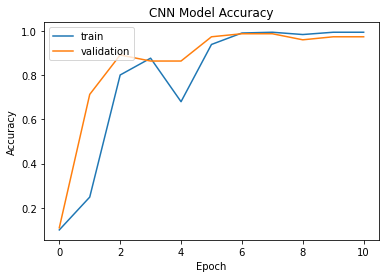

In [39]:
# Plot the accuracy on the train and validation sets
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('CNN Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')

In [40]:
le.inverse_transform([0,1,2,3,4,5,6,7,8,9,10,11])  # show the integer encodings

array(['black-bishop', 'black-king', 'black-knight', 'black-pawn',
       'black-queen', 'black-rook', 'white-bishop', 'white-king',
       'white-knight', 'white-pawn', 'white-queen', 'white-rook'],
      dtype='<U12')

In [41]:
# show the predictions made by the model for the first 6 images in the test set, and the true labels

pred = model.predict(X_test) 
pred = np.argmax(pred, axis = 1)[:6] 
true_ = np.argmax(y_test,axis = 1)[:6] 

print(pred, 'Model predictions') 
print(true_, 'True labels')

[10  2 10  7 11  7] Model predictions
[10  2 10  7 11  7] True labels


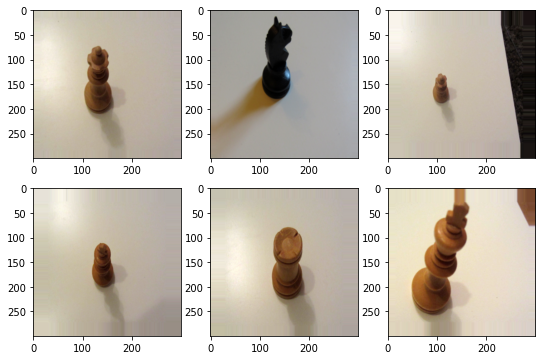

In [43]:
# plot the first 6 images from the test set

from tensorflow.keras.preprocessing.image import array_to_img as arr_to_img

plt.figure(figsize = (9,6))
for i in range(0,6):
    plt.subplot(231 + i)
    plt.imshow(arr_to_img(X_test[i]))


## Conclusions

The project looked at the performance of a Convolutional Neural Network on a classification task using a set of chess piece images. It processed the data into a workable format and evaluated the performance of a deep learning model with tuned hyperparameters. The results indicated near-optimal performance of ~98% in terms of accuracy, indicating excellent generalisation and applicability to new data. 

Further work can consider broader object-recognition applications designed to identify each piece on a chess board and translate it to algebraic format. Such an application would be useful in many ways, especially for translating board positions in over-the-board chess games to a 2D format that is easier to view compared to relying on cameras which suffer from poor viewing angles.

## Bibliography

Data set: https://www.kaggle.com/tannergi/chess-piece-detection/metadata